# From start to finish
Generate a movie of the projections and reconstructions from a selected sample

In [1]:
import os
import glob
import imageio
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import skimage.transform
from tqdm import tqdm_notebook
import time
from IPython import display

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Display and output defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['savefig.dpi'] = 300  # Save (PNG) images with a high DPI

In [4]:
# Setup scale bar
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = '#E6002E'  # unibe red as default scalebar color

In [5]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [6]:
fastSSD = True
if fastSSD:
    BaseFolder = '/media/habi/Fast_SSD/Lung-Metastasis/LR'
else:
    BaseFolder = '/home/habi/1272/Lung-Metastasis/LR'
Sample = 'KP-TNIKWT02'

In [7]:
# Get file names
Logfile = sorted(glob.glob(os.path.join(BaseFolder, Sample, 'proj', '*.log')))[0]
Projections = sorted(glob.glob(os.path.join(BaseFolder, Sample, 'proj', '*[0123456789]?.tif')))
Reconstructions = sorted(glob.glob(os.path.join(BaseFolder, Sample, 'rec', '*.png')))

In [8]:
# Dicard some of the lower reconstructions, which just contain the sample holder
Reconstructions = Reconstructions[211:]

In [9]:
if not Logfile:
    print('Please mount the fast SSD...')

In [10]:
Pixelsize = get_pixelsize(Logfile)
print('We scanned the sample with a voxel size of %0.2f um' % Pixelsize)

We scanned the sample with a voxel size of 21.61 um


In [11]:
# Details of the output movie
Seconds = 10
NumberOfFrames = 24 * Seconds # show animation for $Seconds seconds with a frame rate of 24 fps
WidthOfOutput = 800
my_dpi = 96  # https://www.infobyip.com/detectmonitordpi.php

In [12]:
print('We have %s projections (%s - %s)' % (len(Projections),
                                            os.path.basename(Projections[0]),
                                            os.path.basename(Projections[-1])))
print('and %s reconstructions (%s - %s)' % (len(Reconstructions),
                                            os.path.basename(Reconstructions[0]),
                                            os.path.basename(Reconstructions[-1])))

We have 940 projections (KP-TNIKWT200000000.tif - KP-TNIKWT200000939.tif)
and 556 reconstructions (KP-TNIKWT2_rec00000237.png - KP-TNIKWT2_rec00000792.png)


In [13]:
print('Of these projections and reconstructions I will work with %s equally spaced images' % NumberOfFrames)
print('\tI will downsize these to %s px width' % WidthOfOutput)
print('\tI will draw a scale bar on the images and save them a set of JPG files')

Of these projections and reconstructions I will work with 240 equally spaced images
	I will downsize these to 800 px width
	I will draw a scale bar on the images and save them a set of JPG files


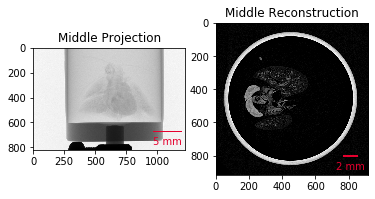

In [14]:
# Show middle images
plt.subplot(121)
plt.imshow(imageio.imread(Projections[len(Projections) // 2]))
plt.gca().add_artist(ScaleBar(Pixelsize, 'um'))
plt.title('Middle Projection')
plt.subplot(122)
plt.imshow(imageio.imread(Reconstructions[len(Reconstructions) // 2]))
plt.gca().add_artist(ScaleBar(Pixelsize, 'um'))
plt.title('Middle Reconstruction')
plt.show()

In [15]:
# Make output directories
os.makedirs(os.path.join(BaseFolder, Sample, 'mov', 'mov_proj'), exist_ok=True)
os.makedirs(os.path.join(BaseFolder, Sample, 'mov', 'mov_rec'), exist_ok=True)

In [16]:
# Generate output folders
OutputNameProj = os.path.join(BaseFolder,
                              Sample,
                              'mov',
                              '%s_%s_projections.mp4' % (Sample, NumberOfFrames))
OutputNameRec = os.path.join(BaseFolder,
                             Sample,
                             'mov',
                             '%s_%s_reconstructions.mp4' % (Sample, NumberOfFrames))

Write out a movie of rescaled projections and reconstructions

In [17]:
# # Write out a movie of rescaled projections
# # based on https://stackoverflow.com/a/35943809/323100
# with imageio.get_writer(OutputNameProj, fps=NumberOfFrames / Seconds) as writer:
#     for filename in tqdm_notebook(Projections[::round(len(Projections) / NumberOfFrames)]):
#         frame = imageio.imread(filename)
#         frame_size = numpy.shape(frame)
#         frame_resized = skimage.transform.rescale(frame, WidthOfOutput / frame_size[1])
#         writer.append_data(skimage.img_as_ubyte(frame_resized))
# print('Saved to %s' % OutputNameProj)

In [18]:
# # Write out a movie of rescaled reconstructions
# # based on https://stackoverflow.com/a/35943809/323100
# with imageio.get_writer(OutputNameRec, fps=NumberOfFrames / Seconds) as writer:
#     for filename in tqdm_notebook(Reconstructions[::round(len(Projections) / NumberOfFrames)]):
#         frame = imageio.imread(filename)
#         frame_size = numpy.shape(frame)
#         frame_resized = skimage.transform.rescale(frame,
#                                                   WidthOfOutput / frame_size[0])
#         writer.append_data(skimage.img_as_ubyte(frame_resized))
# print('Saved to %s' % OutputNameRec)

Write out single frames *with* a scale bar

In [19]:
# Delete files from previous runs
# Based on https://stackoverflow.com/a/37994379/323100
for file in os.scandir(os.path.join(BaseFolder,
                                    Sample,
                                    'mov',
                                    'mov_proj')):
    os.remove(file.path)
for file in os.scandir(os.path.join(BaseFolder,
                                    Sample,
                                    'mov',
                                    'mov_rec')):
    os.remove(file.path)

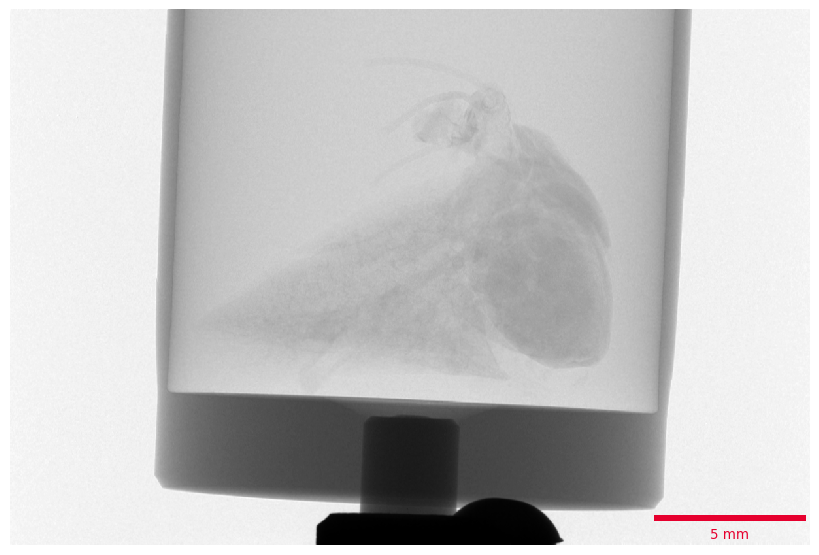


Done


In [20]:
# Let's write the output image with the chosen width (and scaled height)
# Scale the output figure size exactly: https://stackoverflow.com/a/13714720/323100
# Write canvas containts to image: https://stackoverflow.com/a/14913405/323100

for c, filename in tqdm_notebook(enumerate(Projections[::int(numpy.floor(len(Projections) / NumberOfFrames))]),
                                 total=len(Projections[::int(numpy.floor(len(Projections) / NumberOfFrames))])):
    # read image
    image = imageio.imread(filename)
    # Generate a figure with the chosen width and accordingly scaled height
    fig = plt.figure(figsize=(WidthOfOutput/my_dpi,
                              round(WidthOfOutput * (numpy.shape(image)[0] / numpy.shape(image)[1]))/my_dpi),
                     dpi=my_dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(image)
    ax.add_artist(ScaleBar(Pixelsize, 'um'))
    s = '_'
    fig.canvas.print_png(os.path.join(BaseFolder, Sample, 'mov', 'mov_proj',
                                      s.join([Sample,
                                              str(NumberOfFrames),
                                              'projections',
                                              'of',
                                              str(len(Projections)),
                                              str(WidthOfOutput),
                                              'px',
                                              '%03d.jpg' % c])))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.show()
print('Done')

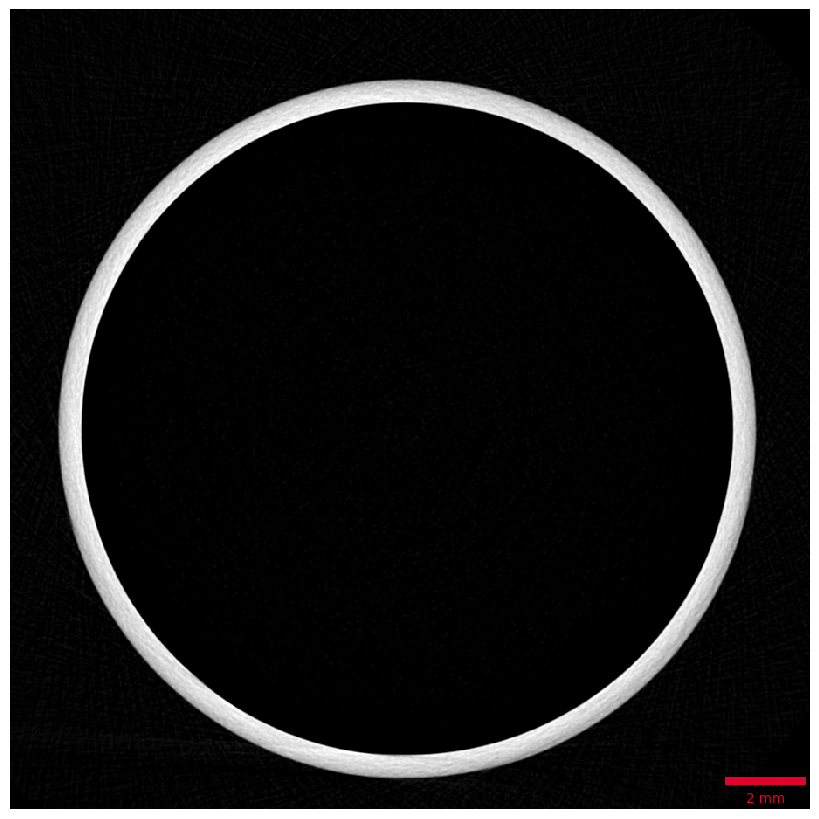


Done


In [22]:
# Let's write the output image with the chosen width (and scaled height)
# Scale the output figure size exactly: https://stackoverflow.com/a/13714720/323100
# Write canvas containts to image: https://stackoverflow.com/a/14913405/323100

for c, filename in tqdm_notebook(enumerate(Reconstructions[::int(numpy.floor(len(Reconstructions) / NumberOfFrames))]),
                                 total=len(Reconstructions[::int(numpy.floor(len(Reconstructions) / NumberOfFrames))])):
    # read image and rotate by 90 degree for presentation
    image = numpy.rot90(imageio.imread(filename))
    # Generate a figure with the chosen width and accordingly scaled height
    fig = plt.figure(figsize=(WidthOfOutput/my_dpi,
                              round(WidthOfOutput * (numpy.shape(image)[0] / numpy.shape(image)[1]))/my_dpi),
                     dpi=my_dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(image)
    ax.add_artist(ScaleBar(Pixelsize, 'um'))
    s = '_'    
    fig.canvas.print_png(os.path.join(BaseFolder, Sample, 'mov', 'mov_rec',
                                      s.join([Sample,
                                              str(NumberOfFrames),
                                              'reconstructions',
                                              'of',
                                              str(len(Reconstructions)),
                                              str(WidthOfOutput),
                                              'px',
                                              '%03d.jpg' % c])))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.show()    
print('Done')  

Now you can convert the frames to a movie with this [`avconv` command](http://simp.ly/publish/3qqCM0)...